# Turnbull

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

In [84]:
%run ../source/models/iceberg/iceberg.py
%run ../source/models/metocean/metocean.py
%run ../source/models/drift/turnbull.py
%run ../source/plotting/plot.py

# Iceberg

In [36]:
chosen_track_ind = 0
iip_berg_df = get_berg_df(2015, chosen_track_ind)
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,6319,2015,21511,6/16/2015,1442,48.16,-50.01,R/V,LG,TAB,GTJZ,2015-06-16 14:42:00
1,6320,2015,21511,6/17/2015,1300,48.09,-50.02,R/V,LG,GEN,GMRS,2015-06-17 13:00:00
2,6321,2015,21511,6/18/2015,1249,48.08,-49.76,VIS,LG,TAB,GTJZ,2015-06-18 12:49:00


In [85]:
iip_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'].loc[0],
                    iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                    [0], [0],
                    iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist(),
                    iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist(),
                    iip_berg_df['SIZE'].loc[0],
                    iip_berg_df['SHAPE'].loc[0])

# Metocean

In [38]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [39]:
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150618.nc']

In [40]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [41]:
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150618.nc']

# Driver

In [86]:
vary_wind = False
vary_current = False

# Run number
run_num = 0
num_runs = 10
mod_berg_list = []


# Buffer number for bounding spatial box
buf = 0.5


for run_num in range(num_runs):

    # Create model iceberg
    mod_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'][0],
                        [iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0]],
                        [0], [0],
                        [iip_berg_df['SIGHTING_LATITUDE'][0]],
                        [iip_berg_df['SIGHTING_LONGITUDE'][0]],
                        iip_berg_df['SIZE'][0], iip_berg_df['SHAPE'].loc[0])

    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]


    # Timesteps
    t0 = iip_berg.datetimes[0]
    tf = iip_berg.datetimes[-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step_hours = 0.1
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []
    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)


    # Iceberg Initial Conditions
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]
    l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
    vx0, vy0 = 0, 0
    
    # Iceberg Initials
    l, w, h = l0, w0, h0
    x, y = x0, y0
    vx, vy = vx0, vy0
    
        
    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))

    for t in t_all:


        t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
        
        vau = atm_data.iUA([t_atm, y, x])[0]
        vav = atm_data.iVA([t_atm, y, x])[0]
        vwu = ocean_data.iUW([t_ocean, y, x])[0]
        vwv = ocean_data.iVW([t_ocean, y, x])[0] 
        
        #print('Timestep: {}'.format(t))

        vx, vy, x, y = turnbull_drift(mod_berg, vau, vav, vwu, vwv, dt) 


        if x > max(iip_berg.lons)+buf or x < min(iip_berg.lons)-buf or y > max(iip_berg.lats)+buf or y <= min(iip_berg.lats)-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        else:
            mod_berg.xvels.append(vx)
            mod_berg.yvels.append(vy)
            mod_berg.lons.append(x)
            mod_berg.lats.append(y)
            mod_berg.datetimes.append(t)

    #mod_berg.datetimes.pop(0)
    print("Final time: {}".format(t)) 

    mod_berg_list.append(mod_berg)

Run number: 0, h = 3382.443362448701, l = 136.07884695007294, w = 150.50115727986477
Final time: 2015-06-18 12:54:00
Run number: 1, h = 3414.623682939461, l = 143.4910082786054, w = 189.14607594234883
Final time: 2015-06-18 12:54:00
Run number: 2, h = 4476.004968883863, l = 123.45319229064881, w = 129.1836905983947
Final time: 2015-06-18 12:54:00
Run number: 3, h = 3975.286605631941, l = 138.72119066046503, w = 154.6838707124992
Final time: 2015-06-18 12:54:00
Run number: 4, h = 4284.341709754108, l = 145.72911547962903, w = 169.06616979286076
Final time: 2015-06-18 12:54:00
Run number: 5, h = 3933.4745984611704, l = 183.8789038472744, w = 125.88766231123186
Final time: 2015-06-18 12:54:00
Run number: 6, h = 4006.829554982958, l = 148.84770856244998, w = 127.2274560932912
Final time: 2015-06-18 12:54:00
Run number: 7, h = 3059.9596259567793, l = 184.27427202234384, w = 191.2729794135694
Final time: 2015-06-18 12:54:00
Run number: 8, h = 2733.9666313638763, l = 141.3371392198602, w = 19

# Plotting

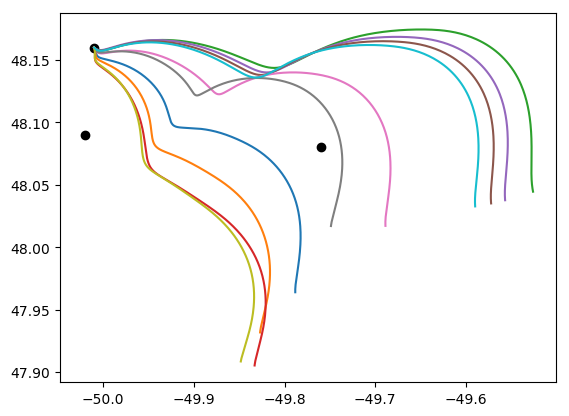

In [87]:
for berg in mod_berg_list:
    plt.plot(berg.lons, berg.lats)
plt.scatter(iip_berg.lons, iip_berg.lats, color='black')

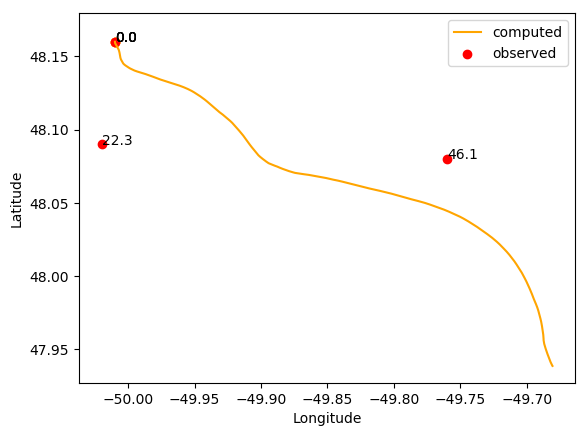

In [13]:
plot = plot_turnbull(iip_berg, mod_berg_list[0])

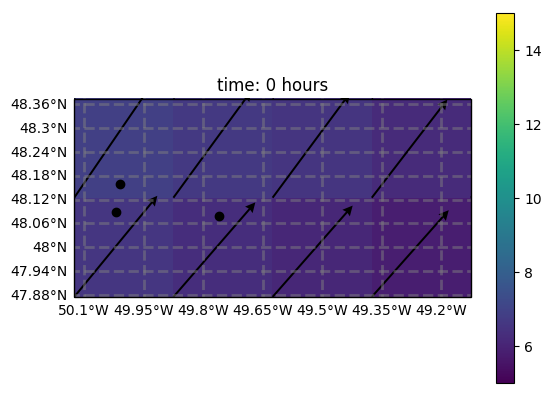

In [52]:
animate_winds(atm_data, iip_berg, mod_berg)

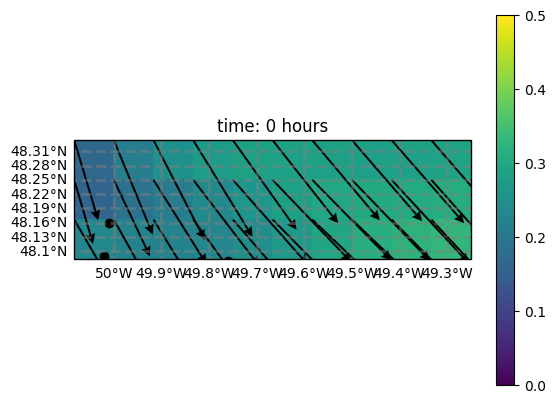

In [54]:
animate_currents(ocean_data, iip_berg, mod_berg)